# New Section

# Foresight Engine : An AI Future-Prediction Engine Based on Time-Series Imagery

### Project Introduction
Our digital world is filled with records of the past—photos, videos, and documents. Can this massive amount of static data help us gain insight into a dynamic future?

**Foresight Engine** is a Proof-of-Concept built on the Google Gemini 1.5 Flash model. It aims to explore the use of large multimodal models to analyze and reason about the evolutionary trends of the physical world based on a sequence of time-ordered images, ultimately generating a visual representation of its future appearance.

### Core Technology
We leverage two core strengths of **Google Gemini 1.5 Flash**:

1.  **Million-Token Long Context Window**: This allows the model to "understand" the entire progression of an event (like a bridge repair) in one go, rather than analyzing isolated images.

2.  **Deep Multimodal Understanding and Generation**: The model not only comprehends image content but also combines visual information with its built-in knowledge of the physical world (such as architecture and engineering) to perform logical reasoning and generate a new, logically consistent future image.

### This Demonstration
In this Notebook, we will demonstrate a specific use case:

* **Input**: A sequence of real photos from a bridge repair project taken over several weeks.**Please following the instruction of "Prepare Your Image Sequence"**

* **Process**: The model will first act as an expert to analyze and describe the construction progress.

* **Output**: Based on its analysis, the model will generate a high-fidelity image predicting the completed state of the bridge at a future point in time.


### How to Prepare Your Image Sequence

For the Foresight Engine to accurately predict the future, it must first understand the past. Please prepare your image files carefully according to these instructions.

1.  **Use a Numerical Sequence:**
Your files must be named using only numbers to represent their order in time. The oldest photo should always be 1.

     * **Correct Sequence**: 1.jpg, 2.jpg, 3.jpg ... 10.jpg, 11.jpg

     * **Incorrect**: Bridge_A.jpg, Phase_2.jpg, Sept_7.jpg

2.  **Ensure Chronological Order**:
Double-check that the number in the filename corresponds to the correct moment in time.
  
        1.jpg = Earliest Image
        The highest number = The most recent image



This is more than just a technical demo; it heralds the immense potential of AI in fields like urban planning, environmental monitoring, agricultural production, and even personal memory management.

### Prompt Template

In [1]:
# This is master template to create prompt for users. The `{subject}` and `{time_frame}` are placeholders.
UNIVERSAL_PROMPT_TEMPLATE = """
You are a world-class expert in time-series image analysis and predictive modeling.
Your goal is to analyze a sequence of images that document a process of change over time.

The user has provided a sequence of images related to: **{subject}**.

Your task is to:

**Analyze and Describe the Process:** Based on the provided images, meticulously describe the step-by-step changes you observe. Identify the key patterns, direction, and pace of the transformation. Your analysis should be objective and grounded in the visual evidence.

Please provide ONLY this detailed analysis as a text response, formatted with a clear title and paragraphs.
"""

In [2]:
# This is our master template for the second step (generation).
# It uses the analysis_text from step 1, and the user's original subject and time_frame.
GENERATION_PROMPT_TEMPLATE = """
Based on the original sequence of images provided, and critically, based on the detailed analysis you just performed:

ANALYSIS:
---
{analysis_text}
---

Your final task is to generate a multi-part response that predicts the future state. Your response MUST contain the following two parts:

**Part 1: The Predicted Image**
Generate a single, photorealistic, high-resolution image that visually represents your prediction for the **{subject}**.
- This image must depict the scene as it would appear **{time_frame}**.
- **Crucial Constraint:** The image must be rendered from the **exact same perspective and viewpoint** as the final photo in the original sequence.
- The lighting, style, and overall atmosphere must be consistent with the original photos, unless logically required to change (e.g., a change of season).

**Part 2: The Rationale Text**
In a detailed paragraph, describe the generated image from Part 1. Explain the logic behind your prediction, citing specific visual evidence from the input images and your analysis that led to your conclusions (e.g., "Given the rate of scaffolding removal in the last three images, I predict it will be entirely gone," or "The plant's growth rate suggests it will have produced fruit by that time.").
"""

In [3]:
API_KEY = "YOUR_API_KEY"
MODEL_ID = "gemini-2.5-flash-image-preview"
MODEL_IMAGE_PATH = '/content/drive/MyDrive/ForesightEngine/nano'


## Implementation

In [4]:
import os
from google import genai
from PIL import Image
from io import BytesIO
from IPython.display import display
from google.colab import drive
import PIL

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Functions

In [5]:
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import display, Markdown

def display_foresight_comparison(input_images: list, foresight_image: PIL.Image.Image, time_frame: str):
    """
    Displays a sequence of input images followed by the AI-generated foresight image
    in a clean, labeled plot.

    Args:
        input_images: A list of PIL.Image objects representing the input sequence.
        foresight_image: A single PIL.Image object representing the prediction.
        time_frame: The user-provided time frame string (e.g., "in four weeks").
    """
    # --- Introduction Text ---
    display(Markdown("---"))
    display(Markdown("## 👁️ Foresight Engine: Visual Comparison"))
    display(Markdown("Below is the sequence of original images provided, followed by the AI-generated prediction."))

    # --- Plotting the Images ---
    num_images = len(input_images) + 1

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 4))

    # In case there is only one input image, axes is not a list
    if num_images == 2:
        axes = [axes[0], axes[1]]

    # Display the input images
    for i, img in enumerate(input_images):
        ax = axes[i]
        ax.imshow(img)
        ax.set_title(f"Input {i+1}")
        ax.axis('off')  # Hide the axes for a cleaner look

    # Display the foresight image with a special title
    ax = axes[-1]
    ax.imshow(foresight_image)

    # Make the foresight title stand out
    foresight_title = f"Foresight:\n{time_frame.title()}"
    ax.set_title(
        foresight_title,
        fontweight='bold',
        fontsize=12,
        color='green'
    )
    ax.axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
# Define function to display
from IPython.display import display, Markdown
from PIL import Image
from io import BytesIO

def process_response(response, display_output=True):
    """
    Processes a multimodal response from the Gemini API.

    It extracts all text and image parts, optionally displays them,
    and returns them for further use.

    Args:
        response: The response object from a model.generate_content() call.
        display_output (bool): If True, displays the content in the notebook.

    Returns:
        tuple: A tuple containing:
            - str: All concatenated text from the response.
            - list: A list of all PIL.Image objects from the response.
    """
    # Initialize variables to store the extracted data
    extracted_text = ""
    extracted_images = []

    if not response.candidates:
        print("Warning: Response has no candidates to process.")
        return extracted_text, extracted_images

    # The primary content is inside response.candidates
    for candidate in response.candidates:
        for part in candidate.content.parts:
            # Extract and optionally display text
            if part.text:
                if display_output:
                    display(Markdown(part.text))
                extracted_text += part.text + "\n" # Add newline for better formatting

            # Extract and optionally display images
            elif hasattr(part, 'inline_data') and part.inline_data.data:
                try:
                    image_bytes = part.inline_data.data
                    image = Image.open(BytesIO(image_bytes))
                    if display_output:
                        display(image)
                    extracted_images.append(image)
                except Exception as e:
                    print(f"Could not process image. Error: {e}")

    return extracted_text.strip(), extracted_images

In [7]:
# To add a new example, simply add a new entry to this dictionary.
EXAMPLES = {
    "bridge_repair": {
        "image_path": "/content/drive/MyDrive/ForesightEngine/images",
        "subject": "the repair process of a large bridge",
        "time_frame": "in six weeks"
    },
    "plant_growth": {
        "image_path": "/content/drive/MyDrive/ForesightEngine/images2",
        "subject": "the growth of a pea from a seedling",
        "time_frame": "in 31 days"
    },
}

In [8]:
from pathlib import Path
import PIL.Image
from io import BytesIO

def run_foresight_engine(name, config, client):
    """
    Runs the entire Foresight Engine workflow for a single example.

    Args:
        config (dict): A dictionary containing 'path', 'subject', and 'time_frame'.
    """
    try:
        # --- 1. Load Input Images ---
        print(f"Loading images from: {config['image_path']}")
        image_dir = Path(config['image_path'])

        image_paths = sorted(
            [p for p in image_dir.glob('*.jpg') if p.stem.isdigit()],
            key=lambda p: int(p.stem)
        )
        input_image_pils = [PIL.Image.open(p) for p in image_paths]
        if not input_image_pils:
            print("Error: No valid images found in the directory. Please check the path and naming.")
            return


        # --- 2. prompt for model to perform analyze ---
        print("Analyzing image sequence...")
        analysis_prompt_text = UNIVERSAL_PROMPT_TEMPLATE.format(
            subject=config['subject'],
            time_frame=config['time_frame']
        )
        analysis_contents = [analysis_prompt_text] + input_image_pils

        print("--- Generated Prompt Sent to AI ---")
        print(analysis_contents)

        # --- Make the API Call ---
        # Call the API to generate the image and text
        analysis_response = client.models.generate_content(
            model=MODEL_ID,
            contents=analysis_contents,
        )

        analysis_text, _ = process_response(analysis_response)

        # Save the analysis_response part to a file
        if analysis_text:
            print("\n Saving analysis text...")
            save_path_text = os.path.join(MODEL_IMAGE_PATH, name + "-analysis_response.txt")
            os.makedirs(os.path.dirname(save_path_text), exist_ok=True)
            with open(save_path_text, 'w') as f:
                f.write(analysis_text)
            print(f"   Text saved successfully to {save_path_text}")

        print(analysis_text)

        # --- 3. Generation Phase (Image Prediction) ---
        print("Generating foresight image...")
        generation_prompt_text = GENERATION_PROMPT_TEMPLATE.format(
            analysis_text=analysis_text,
            subject=config['subject'],
            time_frame=config['time_frame']
        )
        generation_contents = [generation_prompt_text] + input_image_pils

        # --- Make the API Call ---
        generation_response = client.models.generate_content(
            model=MODEL_ID,
            contents=generation_contents,
        )

        generation_text, foresight_images = process_response(generation_response)

        if foresight_images:
          try:
                image_to_save = foresight_images[0]

                save_path_image = os.path.join(MODEL_IMAGE_PATH, name +"-foresight.png")
                os.makedirs(os.path.dirname(save_path_image), exist_ok=True)
                image_to_save.save(save_path_image)
                print(f"Foresight image saved successfully to {save_path_image}")

          except Exception as e:
                # Added error handling for robustness
                print(f"An error occurred while saving the image: {e}")
        else:
            # This runs if the process_response function returned an empty list.
            print("No foresight image was returned by the model, so nothing was saved.")


        # Save the text part to a file
        if generation_text:
            save_path_text = os.path.join(MODEL_IMAGE_PATH, name+"-gener_description.txt")
            os.makedirs(os.path.dirname(save_path_text), exist_ok=True)
            # Save a concise description or a part of the text instead of the entire content
            with open(save_path_text, 'w') as f:
                f.write(generation_text[:255]) # Save first 255 characters as an example

        print(f"Text saved successfully to {save_path_text}")
        print(generation_text)

        # --- 4. Display Results ---
        print("Workflow Complete! Displaying comparison...")

        if foresight_images:
            foresight_pil_image = foresight_images[0]
            #PIL.Image.open(BytesIO(generation_image_parts[0]))
            display_foresight_comparison(
                input_images=input_image_pils,
                foresight_image=foresight_pil_image,
                time_frame=config['time_frame']
            )
        else:
            print("Error: The model did not return an image in the final step.")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")


EXECUTING EXAMPLE: Bridge Repair
Loading images from: /content/drive/MyDrive/ForesightEngine/images
Analyzing image sequence...
--- Generated Prompt Sent to AI ---
['\nYou are a world-class expert in time-series image analysis and predictive modeling.\nYour goal is to analyze a sequence of images that document a process of change over time.\n\nThe user has provided a sequence of images related to: **the repair process of a large bridge**.\n\nYour task is to:\n\n**Analyze and Describe the Process:** Based on the provided images, meticulously describe the step-by-step changes you observe. Identify the key patterns, direction, and pace of the transformation. Your analysis should be objective and grounded in the visual evidence.\n\nPlease provide ONLY this detailed analysis as a text response, formatted with a clear title and paragraphs.\n', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3724x2793 at 0x7EDCC2583E60>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024

Time-Series Analysis: Bridge Repair Process

The sequence of images documents the ongoing repair or construction process of a large bridge, focusing on an area beneath the bridge deck, likely over a body of water. The perspective is consistently from beneath the bridge, looking outwards, with the bridge's underside forming a significant portion of the upper frame.

**Image 1: Initial Setup and Platform Establishment**
The first image captures the initial phase of the operation. A temporary work platform, characterized by its red structural elements and a lighter-colored deck, is clearly visible, extending outwards from beneath the main bridge structure. This platform is supported by multiple red piles driven into the waterbed. A prominent red lattice boom crane stands on the platform, indicating the presence of heavy lifting machinery. On the platform, there are also yellow construction components, possibly temporary storage or additional equipment. In the background, across the water, a cityscape with numerous buildings is visible under a clear, bright blue sky. The water level appears relatively calm.

**Image 2: Expansion of Operations and Material Accumulation**
In the second image, the scene shows an expansion of the operational area and an increase in activity. The temporary work platform appears to have been extended further or has additional sections visible. Another large crane, with a different boom design (possibly a telescopic boom), is now present alongside the initial red lattice boom crane. Several barges or floating work platforms are visible in the water near the bridge piers, suggesting marine-based construction activities. Significantly, a pile of concrete rubble or debris is now present on the riverbank or shallow water directly beneath the main bridge support, indicating demolition or material removal has begun. The sky is now cloudier, suggesting a change in weather or time.

**Image 3: Introduction of Vertical Elements and Increased Equipment**
The third image reveals a significant development: a series of prominent orange vertical cylindrical structures have been installed in the water, extending upwards from the water's surface. These appear to be new piles or caissons, potentially forming part of a new support structure or a temporary cofferdam. The two large cranes from the previous image are still on the work platform, suggesting their continued use in heavy lifting and installation. The overall construction footprint appears to be growing, with more equipment and structural elements in place. The sky remains partly cloudy.

**Image 4: Further Vertical Element Installation and Consolidation**
The final image in the sequence shows the continued installation of the orange vertical structures. More of these cylindrical elements are now visible, extending further along the bridge's length. The cranes are still present on the work platform, seemingly positioned further along the platform, indicating the progression of work along the bridge. The amount of construction activity, particularly the installation of these new vertical components, suggests the process is steadily moving towards establishing new foundational or support elements for the bridge. The sky is depicted with a softer, perhaps early morning or late afternoon light, with some cloud cover. The overall impression is one of sustained, methodical progress in the structural reinforcement or replacement of the bridge's underwater supports.

**Summary of Process:**
The time-series analysis reveals a clear progression in the bridge repair process. It begins with the establishment of a temporary working platform and the introduction of heavy lifting equipment. Subsequently, there is an expansion of the operational area, the accumulation of debris from initial works, and the deployment of marine-based equipment. The most significant development is the systematic installation of new, prominent vertical orange cylindrical structures in the water, suggesting either new foundation piles, temporary support structures, or elements for pier repair/replacement. The continuous presence and movement of cranes on the work platform underscore the ongoing nature of heavy construction and installation tasks. The overall pattern indicates a phased approach, starting with access and preparation, moving to demolition/removal, and then to the installation of new structural components.


 Saving analysis text...
   Text saved successfully to /content/drive/MyDrive/ForesightEngine/nano/bridge_repair-analysis_response.txt
Time-Series Analysis: Bridge Repair Process

The sequence of images documents the ongoing repair or construction process of a large bridge, focusing on an area beneath the bridge deck, likely over a body of water. The perspective is consistently from beneath the bridge, looking outwards, with the bridge's underside forming a significant portion of the upper frame.

**Image 1: Initial Setup and Platform Establishment**
The first image captures the initial phase of the operation. A temporary work platform, characterized by its red structural elements and a lighter-colored deck, is clearly visible, extending outwards from beneath the main bridge structure. This platform is supported by multiple red piles driven into the waterbed. A prominent red lattice boom crane stands on the platform, indicating the presence of heavy lifting machinery. On the platform,

Here is the predicted image for the bridge repair process in six weeks, followed by the rationale.



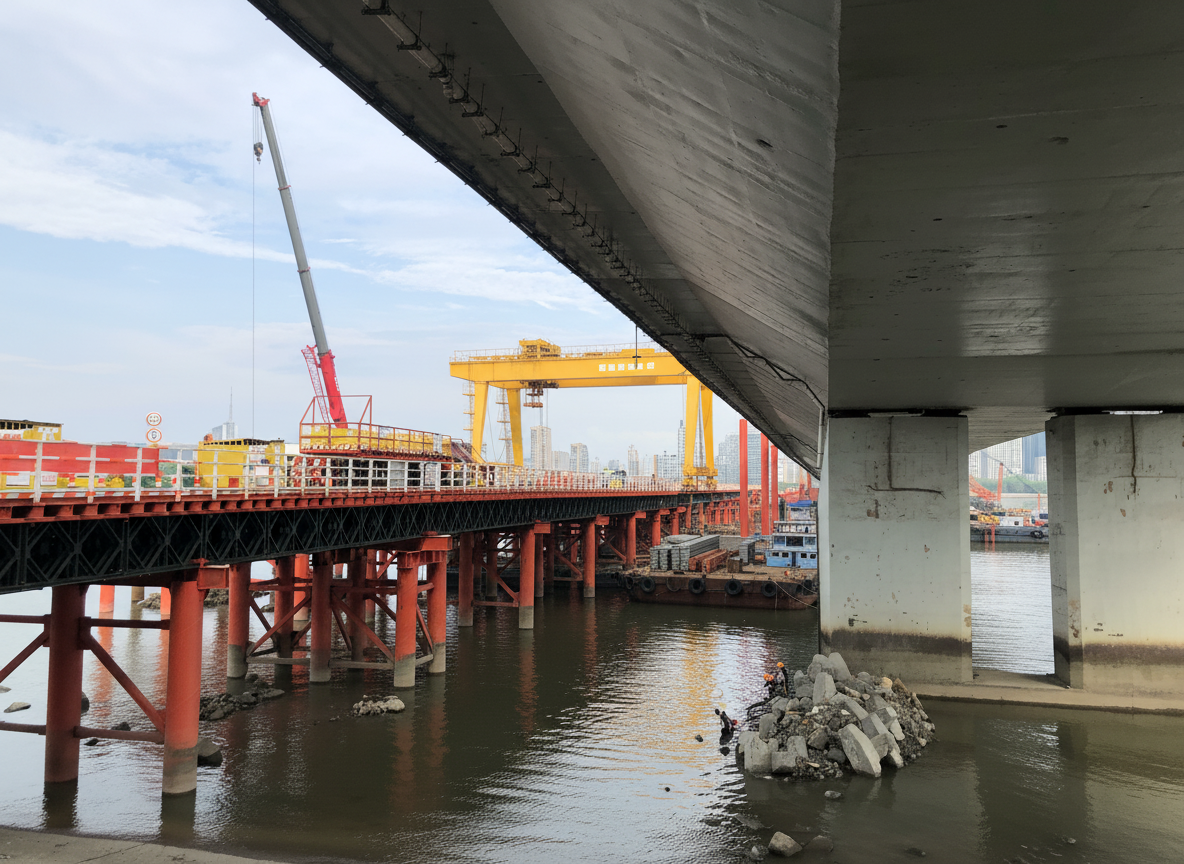

In the predicted image, the bridge repair process shows significant advancement over six weeks, maintaining the original perspective. The temporary work platform has been further extended and modified, with the original red lattice boom crane potentially replaced or augmented by a large yellow gantry crane, signifying the need for heavier lifting and structural assembly. The orange vertical cylindrical structures, first introduced in Image 3 and further expanded in Image 4, are now more numerous and appear to form a more complete array of foundations or supports, possibly with initial capping or preparatory work for subsequent structural elements visible atop some of them. The debris pile on the riverbank has either been removed or significantly reduced, indicating ongoing site clearance, while more barges and floating work platforms are present, underscoring continued marine-based construction activity. This prediction is based on the steady progression observed in the original sequence: the consistent expansion of the work platform, the continuous installation of vertical elements, and the evolving presence of heavy machinery. Given the methodical pace of work from Image 1 to Image 4, six weeks would allow for substantial progress in establishing the new foundational elements and the introduction of equipment suited for the next phase of structural integration, while also tidying up initial demolition debris.

Foresight image saved successfully to /content/drive/MyDrive/ForesightEngine/nano/bridge_repair-foresight.png
Text saved successfully to /content/drive/MyDrive/ForesightEngine/nano/bridge_repair-gener_description.txt
Here is the predicted image for the bridge repair process in six weeks, followed by the rationale.


In the predicted image, the bridge repair process shows significant advancement over six weeks, maintaining the original perspective. The temporary work platform has been further extended and modified, with the original red lattice boom crane potentially replaced or augmented by a large yellow gantry crane, signifying the need for heavier lifting and structural assembly. The orange vertical cylindrical structures, first introduced in Image 3 and further expanded in Image 4, are now more numerous and appear to form a more complete array of foundations or supports, possibly with initial capping or preparatory work for subsequent structural elements visible atop some of them. 

---

## 👁️ Foresight Engine: Visual Comparison

Below is the sequence of original images provided, followed by the AI-generated prediction.

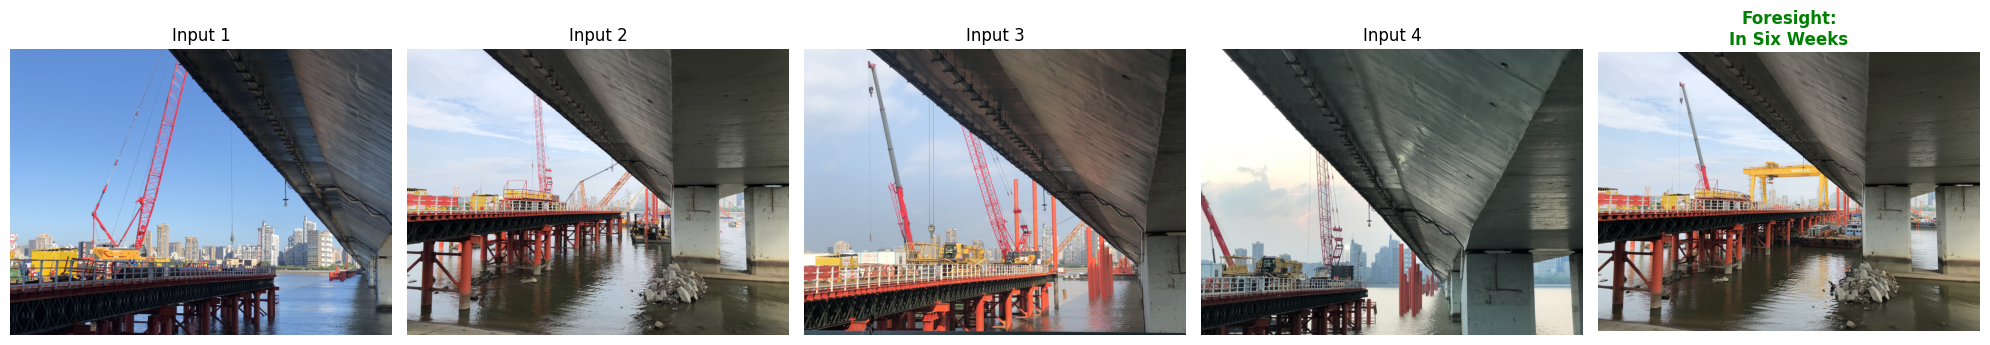


EXECUTING EXAMPLE: Plant Growth
Loading images from: /content/drive/MyDrive/ForesightEngine/images2
Analyzing image sequence...
--- Generated Prompt Sent to AI ---
['\nYou are a world-class expert in time-series image analysis and predictive modeling.\nYour goal is to analyze a sequence of images that document a process of change over time.\n\nThe user has provided a sequence of images related to: **the growth of a pea from a seedling**.\n\nYour task is to:\n\n**Analyze and Describe the Process:** Based on the provided images, meticulously describe the step-by-step changes you observe. Identify the key patterns, direction, and pace of the transformation. Your analysis should be objective and grounded in the visual evidence.\n\nPlease provide ONLY this detailed analysis as a text response, formatted with a clear title and paragraphs.\n', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1905x1146 at 0x7EDCC2583E60>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1704x1029 

Time-Series Analysis: The Growth of a Pea from Seedling

The provided image sequence meticulously documents the germination and early growth stages of a pea plant over a 14-day period. The analysis reveals distinct phases of development, characterized by rapid changes in morphology and orientation.

**Day 0: Initial State**
The process begins with a single, ovoid pea seed nestled within a soil substrate contained in a transparent vessel. The seed appears plump and light in color, indicating its dormant, hydrated state prior to germination. No external signs of growth are yet visible.

**Day 2: Radicle Emergence and Initial Root Growth**
By Day 2, the first discernible change occurs with the emergence of a radicle (embryonic root) from the pea seed. This white, elongated structure extends downwards into the soil, demonstrating gravitropism. The seed itself shows slight swelling and a minor change in its surface texture.

**Day 5: Elongation and Curvature of the Radicle**
The radicle continues to elongate significantly and exhibits a pronounced downward curvature. The seed remains largely unchanged in its position, serving as the anchor point for the developing root system. The overall structure within the soil has become more prominent, indicating continued subterranean development.

**Day 7: Emergence of the Shoot and Cotyledons**
A significant developmental leap is observed by Day 7. A shoot, characterized by a distinct upward growth, has broken through the soil surface. This shoot displays small, emerging leaves (cotyledons) that are distinctly green, indicating the initiation of photosynthesis. The underground portion continues to show root development, although the primary focus of visible growth shifts to the aerial parts.

**Day 9: Leaf Expansion and Tendril Development**
Two days later, the pea plant shows accelerated growth above ground. The initial leaves have expanded considerably, becoming larger and more defined. Crucially, delicate tendrils have begun to form and extend upwards and outwards from the main stem. These tendrils, characteristic of pea plants, suggest the plant is preparing to seek support for vertical growth. The stem has also elongated further, lifting the leaves higher above the soil.

**Day 14: Extensive Shoot and Tendril Development**
By Day 14, the plant has undergone substantial overall growth. The main stem is considerably longer and thicker, supporting a greater biomass of leaves. The leaves are fully expanded and appear robust. The most striking development is the extensive network of tendrils. These tendrils have dramatically elongated and branched, reaching outwards and upwards, demonstrating a clear thigmotropic (touch-responsive) growth pattern. The plant has transformed from a subterranean seed to a complex seedling with both a developed root system (implied by continued healthy growth) and a significant aerial structure poised for climbing. The direction of growth is overwhelmingly upward and outward, maximizing light exposure and potential for physical support. The pace of visible change appears to accelerate, particularly between Day 7 and Day 14.


 Saving analysis text...
   Text saved successfully to /content/drive/MyDrive/ForesightEngine/nano/plant_growth-analysis_response.txt
Time-Series Analysis: The Growth of a Pea from Seedling

The provided image sequence meticulously documents the germination and early growth stages of a pea plant over a 14-day period. The analysis reveals distinct phases of development, characterized by rapid changes in morphology and orientation.

**Day 0: Initial State**
The process begins with a single, ovoid pea seed nestled within a soil substrate contained in a transparent vessel. The seed appears plump and light in color, indicating its dormant, hydrated state prior to germination. No external signs of growth are yet visible.

**Day 2: Radicle Emergence and Initial Root Growth**
By Day 2, the first discernible change occurs with the emergence of a radicle (embryonic root) from the pea seed. This white, elongated structure extends downwards into the soil, demonstrating gravitropism. The seed itse

Here is the predicted image for the pea plant in 31 days, followed by the rationale.



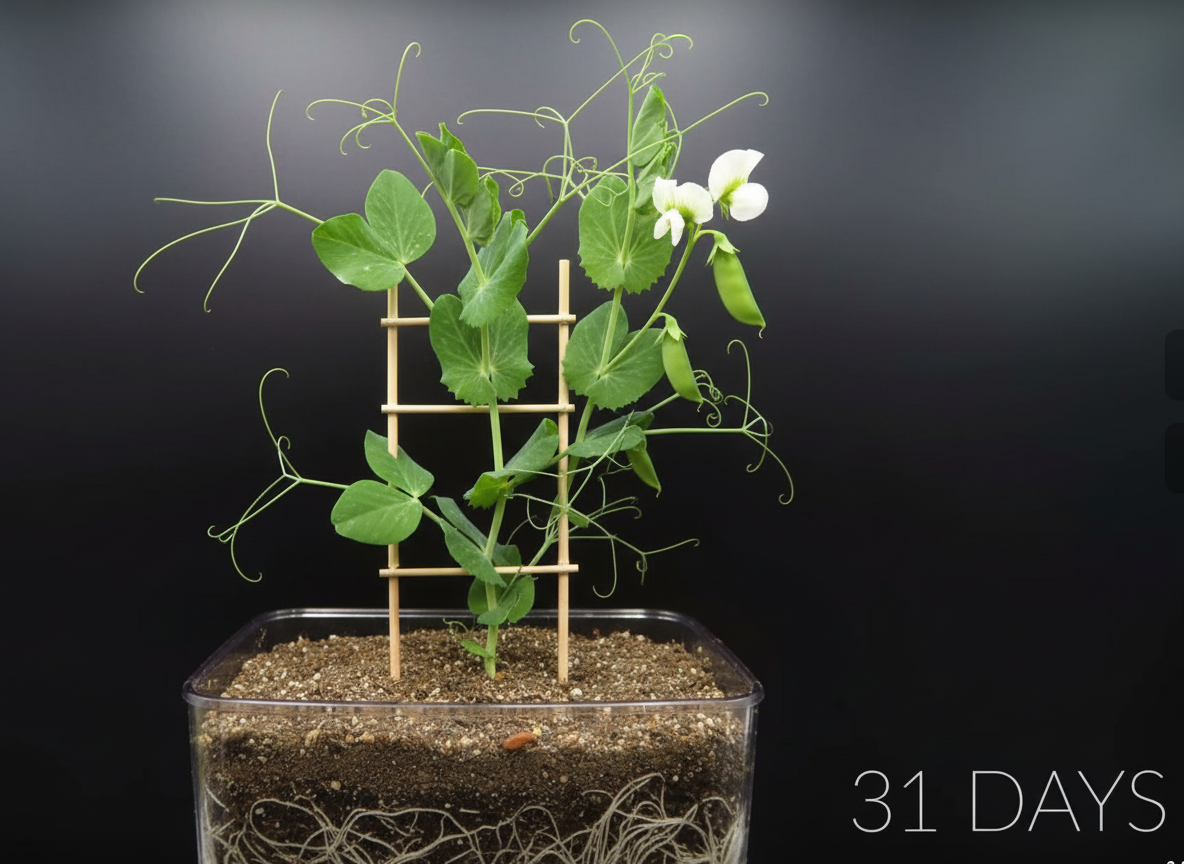

Based on the observed growth rate and characteristics up to Day 14, the predicted image for Day 31 shows a significantly more mature and developed pea plant. The plant has grown much taller, extending well above the confines of the initial container, and its numerous tendrils have successfully attached to a small wooden trellis, demonstrating the thigmotropic growth observed in the original sequence. The leaves are fully unfurled, larger, and more abundant, reflecting increased photosynthetic activity. Crucially, the plant has begun to flower, with several white pea blossoms visible, indicating it has reached a reproductive stage. Furthermore, several young pea pods are already forming, suggesting that the accelerated growth between Day 7 and Day 14 has continued, allowing for rapid progression through its life cycle. The root system visible through the transparent container is also much more extensive and denser, supporting the increased aerial biomass. The overall form suggests a healthy, productive pea plant, fulfilling its natural climbing habit.

Foresight image saved successfully to /content/drive/MyDrive/ForesightEngine/nano/plant_growth-foresight.png
Text saved successfully to /content/drive/MyDrive/ForesightEngine/nano/plant_growth-gener_description.txt
Here is the predicted image for the pea plant in 31 days, followed by the rationale.


Based on the observed growth rate and characteristics up to Day 14, the predicted image for Day 31 shows a significantly more mature and developed pea plant. The plant has grown much taller, extending well above the confines of the initial container, and its numerous tendrils have successfully attached to a small wooden trellis, demonstrating the thigmotropic growth observed in the original sequence. The leaves are fully unfurled, larger, and more abundant, reflecting increased photosynthetic activity. Crucially, the plant has begun to flower, with several white pea blossoms visible, indicating it has reached a reproductive stage. Furthermore, several young pea pods are already forming, su

---

## 👁️ Foresight Engine: Visual Comparison

Below is the sequence of original images provided, followed by the AI-generated prediction.

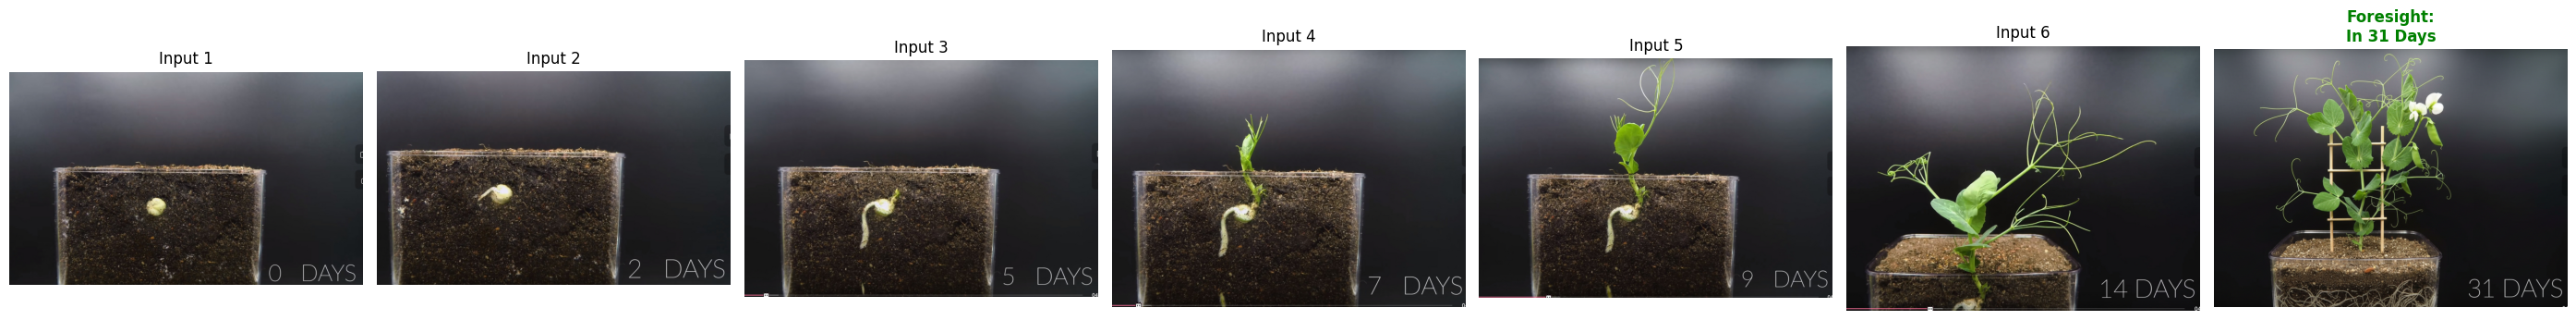

In [9]:
# ==============================================================================
# RUN ALL EXAMPLES
# ==============================================================================

client = genai.Client(api_key=API_KEY)

for name, config in EXAMPLES.items():
    print("\n" + "="*80)
    print(f"EXECUTING EXAMPLE: {name.replace('_', ' ').title()}")
    print("="*80)
    run_foresight_engine(name,config,client)

## Technology Stack

The core of **Foresight Engine** is to leverage cutting-edge artificial intelligence to empower predictive visual analysis. We chose a concise yet powerful technology stack to ensure rapid prototype development within the limited time of a hackathon.

* **Core AI Engine:**
    * **Google Gemini 1.5 Flash:** This is the cornerstone of the project. We utilize its **million-token long context window** to process and understand the entire image sequence at once, and its **deep multimodal understanding and generation capabilities** to combine visual analysis with real-world knowledge, ultimately producing high-quality predictive images.

* **Development & Runtime Environment:**
    * **Google Colab:** As a fully cloud-based Notebook environment, Colab provides us with free GPU acceleration, convenient dependency management, and seamless Google Drive integration, making it the ideal choice for prototyping AI projects of this nature.

* **Core Python Libraries:**
    * `google-generativeai`: The official Google Python SDK for interacting with the Gemini API.
    * `Pillow (PIL)`: A powerful image processing library used to load, process, and manipulate the user-provided image sequence.
    * `Matplotlib`: A mature data visualization library used to create clean, professional image comparison views that intuitively showcase the "past" and the "future".
    * `pathlib`: Python's modern module for handling filesystem paths, used to automatically and safely retrieve user-input image files.

---

### Future Outlook

This hackathon project has successfully validated the core concept of the **Foresight Engine**. We believe this is just the beginning. In the future, the engine can evolve from a prototype into a powerful platform, creating immense value across multiple vertical domains.

**1. From Prototype to Product:**

* **Web Application:** Develop a user-friendly web interface that allows non-technical users to upload image sequences via simple drag-and-drop and receive prediction results online.
* **Video Input Support:** Allow users to directly upload timelapse videos. The engine will automatically extract keyframes for analysis, further lowering the barrier to entry.

**2. Enhanced Predictive Capabilities:**

* **Interactive Prediction:** Allow users to introduce variables into the prediction. For instance, in a construction project, a user could ask, "What would the final result look like if the exterior was finished with a glass curtain wall instead of stone?"
* **Multi-View Fusion:** Train the model to process images from different (but similar) perspectives, synthesizing a unified, standardized viewpoint through AI algorithms to generate smoother dynamic changes and more accurate predictions.

**3. Deep Applications in Vertical Domains:**

* **Urban Planning & Architecture:** Combine drone imagery with Building Information Modeling (BIM) to monitor construction progress in real-time and predict project completion dates and final appearances with high precision.
* **Environmental Science:** Analyze years of satellite imagery to predict glacial melt, forest degradation, coastline changes, and urban sprawl due to climate change, providing intuitive data support for policymaking.
* **Precision Agriculture:** Predict crop growth, pest trends, and optimal harvest times by analyzing continuous aerial photos of farmland, aiding smart agriculture.
* **Medical Imaging:** Assist doctors in predicting tumor growth trends or post-operative tissue healing by analyzing sequential medical scans (like MRIs).

**4. Responsible AI:**

* **Preventing Misuse:** Establish strict ethical guardrails and usage policies, especially in sensitive areas like predicting changes in human appearance (e.g., aging).
* **Content Provenance:** Automatically add invisible digital watermarks to all AI-generated images, clearly identifying them as AI-generated content to prevent the spread of misinformation.

We believe that **Foresight Engine** is more than just an image generation tool; it is a bridge connecting the past and the future, a decision-support engine capable of turning data into insight.